# **Proyecto Integrador**


## **Avance 1. Análisis exploratorio de datos**

---
**Prof. Titulares:**

Dra. Grettel Barceló Alonso

Dr. Luis Eduardo Falcón Morales

**Prof.a Tutora:**

Mtra. Verónica Sandra Guzmán de Valle


---

**Integrantes Equipo 3:**

Julián David Góngora Forero - A01793036

José Javier Granados Hernández - A00566717

Karel Alejandro Cuevas Hernández - A00301492

In [ ]:
#!pip install nltk pyspellchecker
#!pip install squarify
from google.colab import drive
import mailbox
from email import message_from_string
from email.header import decode_header, make_header
import base64
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
import nltk
from spellchecker import SpellChecker
from nltk.tokenize import word_tokenize
from tqdm import tqdm
from joblib import Parallel, delayed
import spacy
import squarify
from wordcloud import WordCloud
from email.utils import parsedate_to_datetime
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Monta Google Drive
drive.mount('/content/drive')

# Ruta del archivo mbox en Google Drive
ruta_del_archivo = '/content/drive/MyDrive/Proyecto Integrador/Avance 1/Topgolf.mbox'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Función para manejar errores al decodificar
def decodeErrorHandle(message):
    try:
        messageOut = message.get_payload(decode=True).decode()
    except UnicodeDecodeError:
        messageOut = 'Unable to decode UTF-8'
    return messageOut

In [ ]:
# Función para procesar mbox y obtener detalles de correos


def process_mbox(file_path, your_email):
    mbox = mailbox.mbox(file_path)
    email_details = []

    for msg in mbox:
        email_dict = {}
        sender = msg.get('From')
        email_dict['sent_or_receive'] = 'Sent' if sender and your_email in sender else 'Received'
        email_dict['email_address'] = sender if email_dict['sent_or_receive'] == 'Sent' else msg.get('To')

        if msg.is_multipart():
            for part in msg.walk():
                if part.get_content_type() == 'text/plain':
                    email_dict['message'] = decodeErrorHandle(part)
                    break
        else:
            email_dict['message'] = decodeErrorHandle(msg)

        date = parsedate_to_datetime(msg.get('Date'))
        email_dict['date'] = date
        email_details.append(email_dict)

    return email_details


In [ ]:
# Leer correos y procesar
fileName = '/content/drive/MyDrive/Proyecto Integrador/Avance 1/Topgolf.mbox'
emails = process_mbox(fileName, 'topgolf@inmomentfeedback.com')

# Crear DataFrame con detalles de correos
df = pd.DataFrame(emails)

In [ ]:
# Filtrar direcciones de correo electrónico
email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
def find_email(text):
    if text is None:
        return None
    listEmails = re.findall(email_pattern, text)
    if listEmails is None:
        return text
    if len(listEmails) == 0:
        return listEmails
    while listEmails:
        mail = listEmails.pop()
        if "topgolf.com" not in mail:
            return mail
    return mail

df['clean_email'] = df['email_address'].apply(lambda x: find_email(x))

In [ ]:
# Crear columna dummy para identificar comunicación interna
df['internal_email_dummy'] = np.where(df['email_address'].str.contains('topgolf'), 1, 0)

df_ext = df[df['internal_email_dummy'] == 1]

In [ ]:
# Extraer líneas de texto del cliente
def extract_customer_text(text, line_start_symbol='>'):
    pattern = rf'^{line_start_symbol}.*$'
    lines_out = re.findall(pattern, text, re.MULTILINE)
    return lines_out

df['customer_text'] = df['message'].apply(lambda x: extract_customer_text(x) if type(x) is not float else '')
df['customer_text'] = df['customer_text'].apply(lambda x: '' if type(x) == list and len(x) == 0 else x)

df_customer_text = df[df['internal_email_dummy'] == 0].copy()

In [ ]:
# Spell checker y procesamiento de texto
nltk.download('punkt')
nltk.download('stopwords')
spell = SpellChecker(language='es')

def process_text(text_in_list, spell_check=False, delete_unrecognized_words=False):
    text = '\n'.join(text_in_list)
    pattern = re.compile(r'[^\w\s\d]\_', re.UNICODE)
    filtered_text = pattern.sub('', text)

    words = word_tokenize(filtered_text)

    if spell_check:
        corrected_words = []
        for word in words:
            if word.isalpha():
                if spell.correction(word) is not None:
                    corrected_words.append(spell.correction(word))
                elif delete_unrecognized_words and spell.correction(word) is None:
                    pass
                else:
                    corrected_words.append(word)
    else:
        corrected_words = [word for word in words if word.isalpha()]

    return corrected_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Procesar texto con spell check y sin eliminación de palabras no reconocidas
df_customer_text['customer_filtered_corrected_text_spellcheck_noworddelete'] = df_customer_text['customer_text'].apply(lambda x: process_text(x, spell_check=True))

In [ ]:
# Procesar texto con spell check y eliminación de palabras no reconocidas
df_customer_text['customer_filtered_corrected_text_spellcheck_worddelete'] = df_customer_text['customer_text'].apply(lambda x: process_text(x, spell_check=True, delete_unrecognized_words=True))


In [ ]:
df_customer_text

sent_or_receive                                      email_address  \
38          Received  =?UTF-8?Q?Yuliana_Bola=C3=B1os?= <yuliana13211...   
45          Received          angel Saucedo <saucedoangel391@gmail.com>   
49          Received                        lauram <lauram@siguesi.com>   
68          Received  Eduardo Villarreal <eduardo_miguel99@hotmail.com>   
86          Received  =?UTF-8?Q?Claudia_Guzm=C3=A1n?= <claudiaguzman...   
...              ...                                                ...   
6575        Received        "Moreno, Tania" <tania.moreno@argia.com.mx>   
6578        Received  Leslie Jaitzel Campos Salas <leslie.campos@coe...   
6579        Received   Jorge Oseguera <jorge.oseguera@delectric.com.mx>   
6582        Received            Rodrigo Cornejo <rocornejo@hotmail.com>   
6585        Received              Bethel Group <bethelgroup7@gmail.com>   

                           date  \
38    2024-01-05 08:35:17-06:00   
45    2024-01-02 12:28:50-06:00   
49    2024-01-01 17:03:34-06:00   
68    2023-12-24 15:01:08-06:00   
86    2023-12-21 09:57:23-06:00   
...                         ...   
6575  2021-06-28 18:55:30-05:00   
6578  2021-06-28 16:57:34-05:00   
6579  2021-06-28 11:48:52-05:00   
6582  2021-06-25 12:36:07-05:00   
6585  2021-06-22 18:14:47-05:00   

                                                message  \
38    Yuliana muy buenos días,\r\n\r\nSoy Eduardo Ma...   
45     Hola!\r\n\r\nPuedes comunicarte por favor con...   
49    Buenas tardes y feliz año.\r\nPueden ir direct...   
68    Hola\r\nClaro que si, que día quisieras canjea...   
86    Claudia muy buenos días,\r\n\r\nSoy Eduardo Ma...   
...                                                 ...   
6575  Gracias por contactarte con nosotros,\r\nAnexa...   
6578  Hola Leslie, buenas tardes\r\n¡Claro! te comen...   
6579  Hola Jorge\r\n¡Claro! te anexamos tu factura, ...   
6582  Hola Rodrigo buenas tardes,\r\nAnexo Factura\r...   
6585  Hola Elizabeth,\r\n Ya pueden ingresar niños d...   

                          clean_email  internal_email_dummy  \
38            yuliana132112@gmail.com                     0   
45          saucedoangel391@gmail.com                     0   
49                 lauram@siguesi.com                     0   
68       eduardo_miguel99@hotmail.com                     0   
86          claudiaguzman05@gmail.com                     0   
...                               ...                   ...   
6575        tania.moreno@argia.com.mx                     0   
6578    leslie.campos@coelabogados.mx                     0   
6579  jorge.oseguera@delectric.com.mx                     0   
6582            rocornejo@hotmail.com                     0   
6585           bethelgroup7@gmail.com                     0   

                                          customer_text  \
38    [> Me quejaré de la recepción, son clasistas, ...   
45    [> Hola buenas tardes, me llamo ángel Ernesto ...   
49    [>\r, > Buenas tardes\r, >\r, > He estado marc...   
68    [> Hola Buenas Tardes,\r, >\r, > Mi nombre es ...   
86    [> No me permite escribir más de 1 renglón ni ...   
...                                                 ...   
6575  [> Buen día,\r, >\r, > Me pueden apoyar con la...   
6578  [> Buenos días,\r, >\r, > Quiero pedir de su a...   
6579  [> Buenos días\r, > La pagina no me deja factu...   
6582  [> Hola!\r, > Quiero pedir su ayuda para tener...   
6585  [>\r, > Hola buenas tardes, solo para confirma...   

     customer_filtered_corrected_text_spellcheck_noworddelete  \
38    [Me, quejar, de, la, recepción, son, clasistas...         
45    [Hola, buena, tarde, me, llama, ángel, resto, ...         
49    [buena, tarde, He, estado, mercado, y, no, log...         
68    [Hola, buena, tarde, Mi, nombre, es, dardo, Vi...         
86    [No, me, permiso, escribir, más, de, renglón, ...         
...                                                 ...         
6575  [Buen, día, Me, pueden, apoyar, con, la, factu.

In [ ]:
# Análisis de frecuencia de palabras
# Crear funciones para visualización de frecuencias
def plot_pareto_chart(word_freq, title):
    sorted_words = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    num_words_to_display = len(sorted_words) // 6

    plt.figure(figsize=(12, 4))
    plt.bar(list(sorted_words.keys())[:num_words_to_display], list(sorted_words.values())[:num_words_to_display])
    plt.xlabel('Palabras')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45, fontsize=8, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()

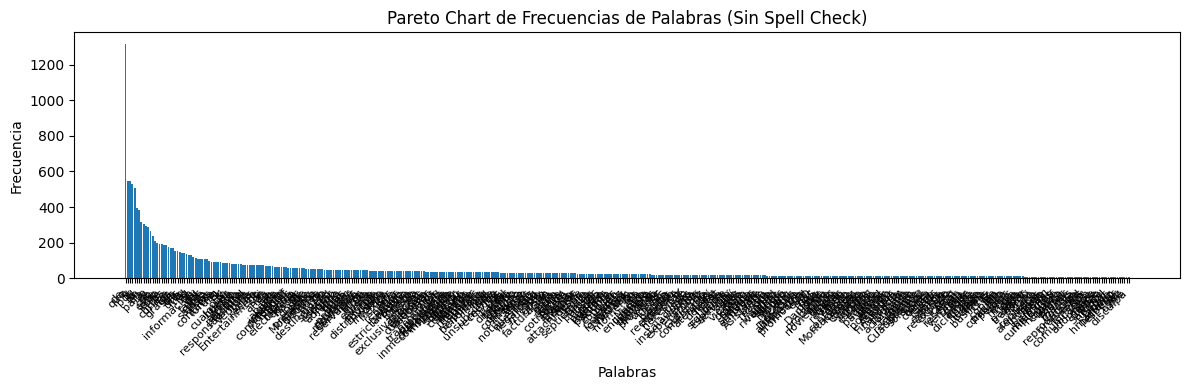

In [ ]:
# Pareto Chart de palabras sin spell check y eliminación de palabras no reconocidas
all_words = [word for words_list in df_customer_text['customer_filtered_corrected_text_spellcheck_noworddelete'] for word in words_list]
word_freq = Counter(all_words)
plot_pareto_chart(word_freq, 'Pareto Chart de Frecuencias de Palabras (Sin Spell Check)')


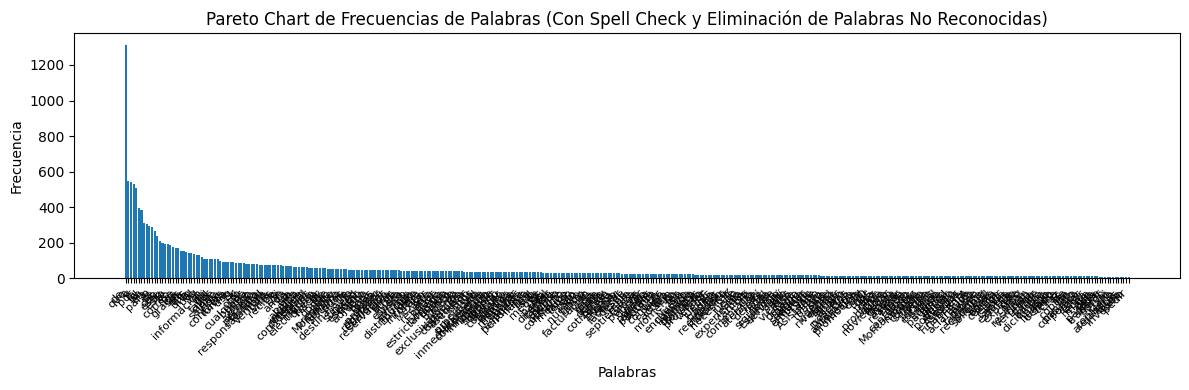

In [ ]:
# Pareto Chart de palabras con spell check y eliminación de palabras no reconocidas
all_words_spellcheck_worddelete = [word for words_list in df_customer_text['customer_filtered_corrected_text_spellcheck_worddelete'] for word in words_list]
word_freq_spellcheck_worddelete = Counter(all_words_spellcheck_worddelete)
plot_pareto_chart(word_freq_spellcheck_worddelete, 'Pareto Chart de Frecuencias de Palabras (Con Spell Check y Eliminación de Palabras No Reconocidas)')

In [ ]:
# Categorización de palabras y análisis de frecuencias
# Función para procesar texto y categorizar palabras
def categorize_words(texts):
    adjectives = []
    verbs = []
    nouns = []

    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        for token in doc:
            if not token.is_stop and token.is_alpha:
                lower_word = token.text.lower()
                if token.pos_ == 'ADJ':
                    adjectives.append(lower_word)
                elif token.pos_ == 'VERB':
                    verbs.append(lower_word)
                elif token.pos_ == 'NOUN':
                    nouns.append(lower_word)

    return adjectives, verbs, nouns

In [ ]:
#!python -m spacy download es_core_news_sm
# Load the Spanish NLP model
nlp = spacy.load('es_core_news_sm')


# Textos como cadenas para procesamiento
texts = [' '.join(words_list).lower() for words_list in df_customer_text['customer_filtered_corrected_text_spellcheck_noworddelete']]

# Categorización de palabras
adjectives, verbs, nouns = categorize_words(texts)

# Frecuencia de cada categoría
adjective_freq = Counter(adjectives)
verb_freq = Counter(verbs)
noun_freq = Counter(nouns)

In [ ]:
print("Adjetivos:", adjective_freq, "\nVerbos:", verb_freq, "\nSustantivos:", noun_freq)

Adjetivos: Counter({'libre': 73, 'confidencial': 61, 'adjunto': 58, 'electrónico': 56, 'clica': 44, 'enviado': 41, 'borrego': 39, 'distribución': 38, 'dirigidas': 37, 'transmitidos': 36, 'subsidiaria': 36, 'copado': 36, 'tris': 34, 'lino': 33, 'contacto': 32, 'notifications': 29, 'topil': 29, 'contracto': 27, 'tenso': 26, 'seno': 26, 'pendiente': 25, 'saludo': 25, 'presente': 17, 'anda': 17, 'blanco': 16, 'llamada': 16, 'vigente': 15, 'verónica': 15, 'rivera': 15, 'espinosa': 15, 'tejo': 15, 'topgolf': 14, 'social': 14, 'ca': 13, 'frida': 13, 'danfoss': 13, 'oficial': 12, 'vista': 12, 'poderoso': 12, 'financiera': 12, 'moble': 11, 'recipiente': 11, 'seria': 11, 'importante': 11, 'externa': 11, 'lindo': 11, 'experto': 11, 'copina': 10, 'nacional': 10, 'polaca': 10, 'internacional': 9, 'cita': 9, 'industrial': 9, 'fiscal': 9, 'normal': 9, 'roble': 9, 'antemano': 8, 'solio': 8, 'individual': 8, 'necesario': 8, 'legal': 8, 'strictly': 8, 'privilegiada': 8, 'pronta': 8, 'disponible': 7, 'vá

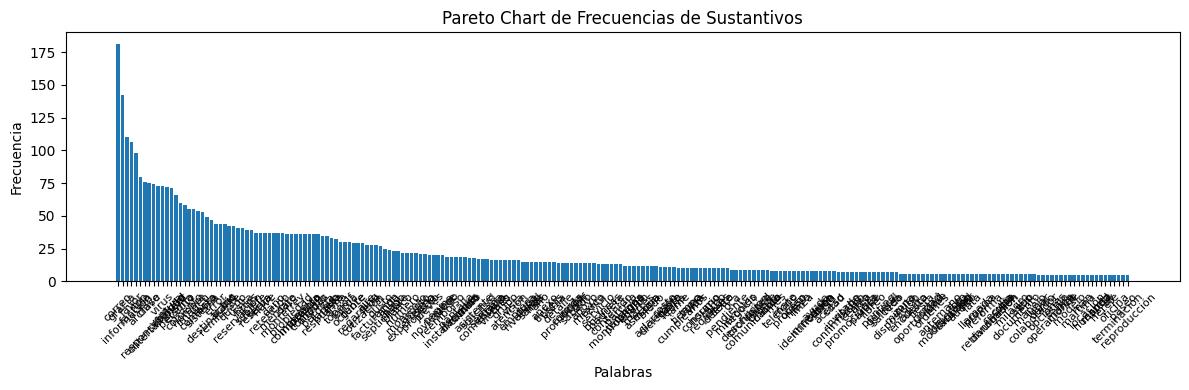

In [ ]:
# Pareto Chart de sustantivos
sorted_nouns = dict(sorted(noun_freq.items(), key=lambda item: item[1], reverse=True))
num_words_to_display = len(sorted_nouns) // 4
plt.figure(figsize=(12, 4))
plt.bar(list(sorted_nouns.keys())[:num_words_to_display], list(sorted_nouns.values())[:num_words_to_display])
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, fontsize=8)
plt.title('Pareto Chart de Frecuencias de Sustantivos')
plt.tight_layout()
plt.show()

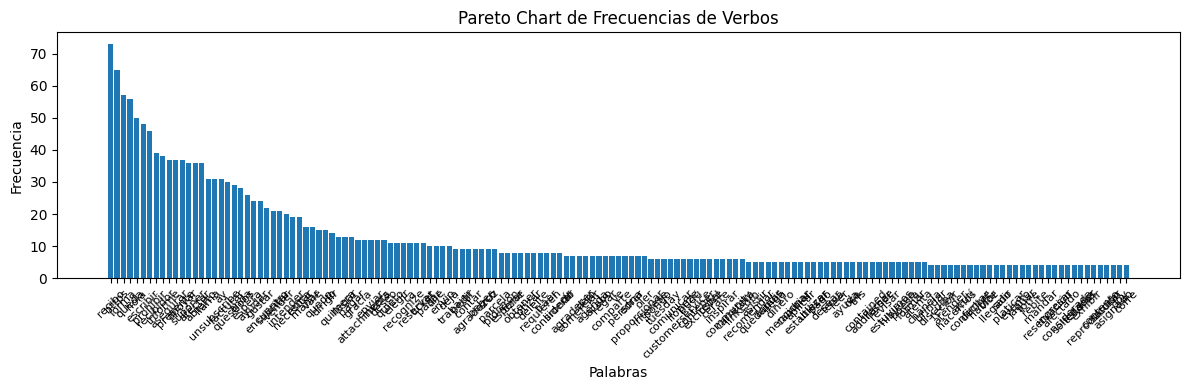

In [ ]:
# Pareto Chart de verbos
sorted_verbs = dict(sorted(verb_freq.items(), key=lambda item: item[1], reverse=True))
num_words_to_display = len(sorted_verbs) // 4
plt.figure(figsize=(12, 4))
plt.bar(list(sorted_verbs.keys())[:num_words_to_display], list(sorted_verbs.values())[:num_words_to_display])
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, fontsize=8)
plt.title('Pareto Chart de Frecuencias de Verbos')
plt.tight_layout()
plt.show()

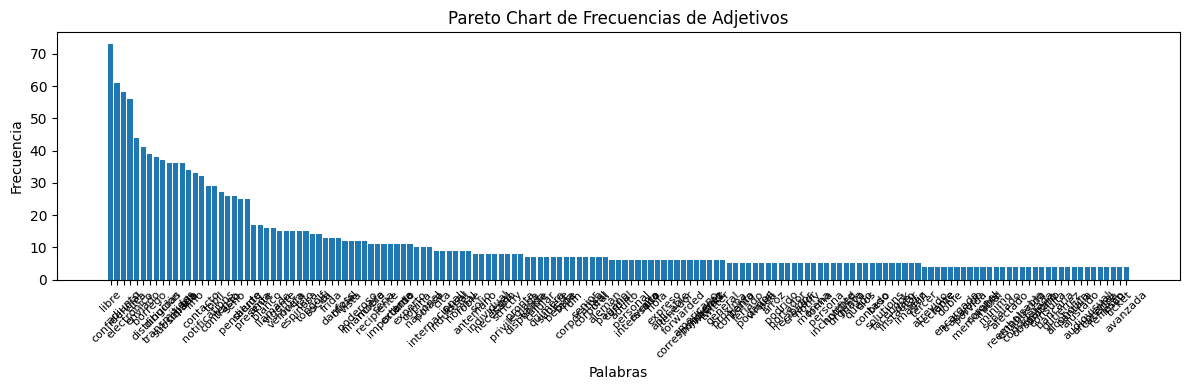

In [ ]:
# Pareto Chart de adjetivos
sorted_adjs = dict(sorted(adjective_freq.items(), key=lambda item: item[1], reverse=True))
num_words_to_display = len(sorted_adjs) // 4
plt.figure(figsize=(12, 4))
plt.bar(list(sorted_adjs.keys())[:num_words_to_display], list(sorted_adjs.values())[:num_words_to_display])
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, fontsize=8)
plt.title('Pareto Chart de Frecuencias de Adjetivos')
plt.tight_layout()
plt.show()

In [ ]:
# Treemaps y Word Clouds
# Función para visualizar un treemap
def plot_treemap(freq_dict, title):
    cmap = plt.cm.Blues
    mini = min(freq_dict.values())
    maxi = max(freq_dict.values())
    norm = plt.Normalize(vmin=mini, vmax=maxi)
    colors = [cmap(norm(value)) for value in freq_dict.values()]

    plt.figure(figsize=(12, 8))
    squarify.plot(sizes=freq_dict.values(), label=freq_dict.keys(), color=colors, alpha=0.6)
    plt.axis('off')
    plt.title(title)
    plt.show()

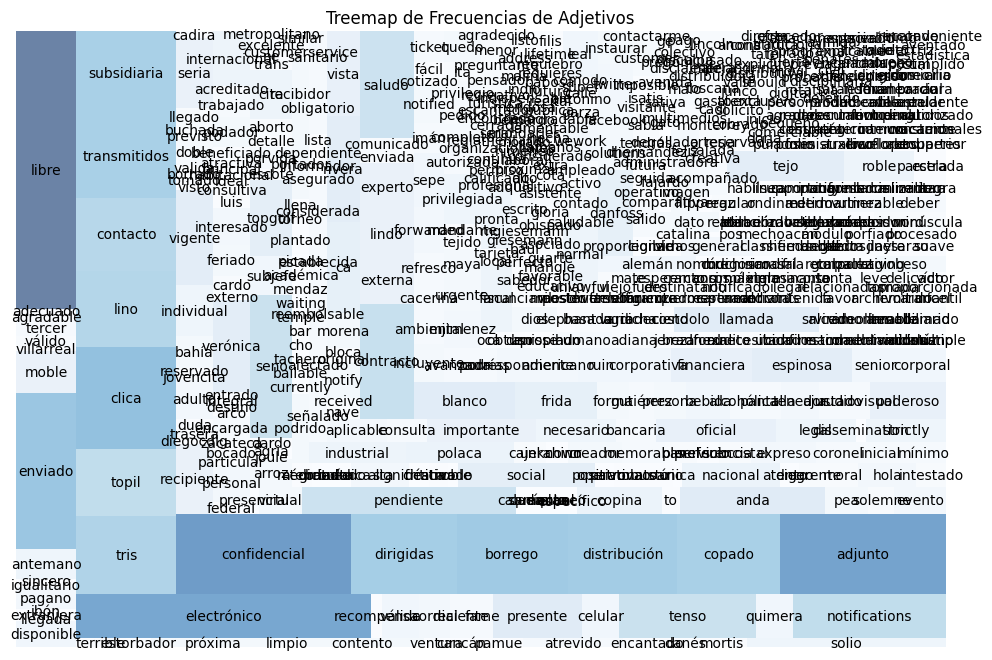

In [ ]:
# Treemap de adjetivos
plot_treemap(adjective_freq, 'Treemap de Frecuencias de Adjetivos')

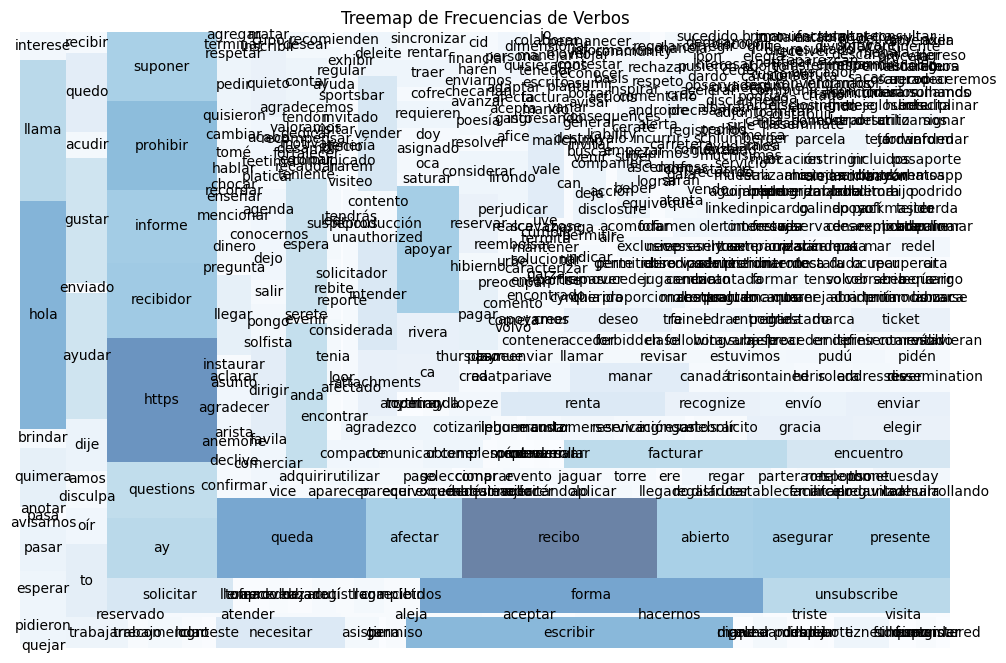

In [ ]:
# Treemap de verbos
plot_treemap(verb_freq, 'Treemap de Frecuencias de Verbos')

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44048 (\N{HANGUL SYLLABLE GAM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54633 (\N{HANGUL SYLLABLE HAB}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45768 (\N{HANGUL SYLLABLE NI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


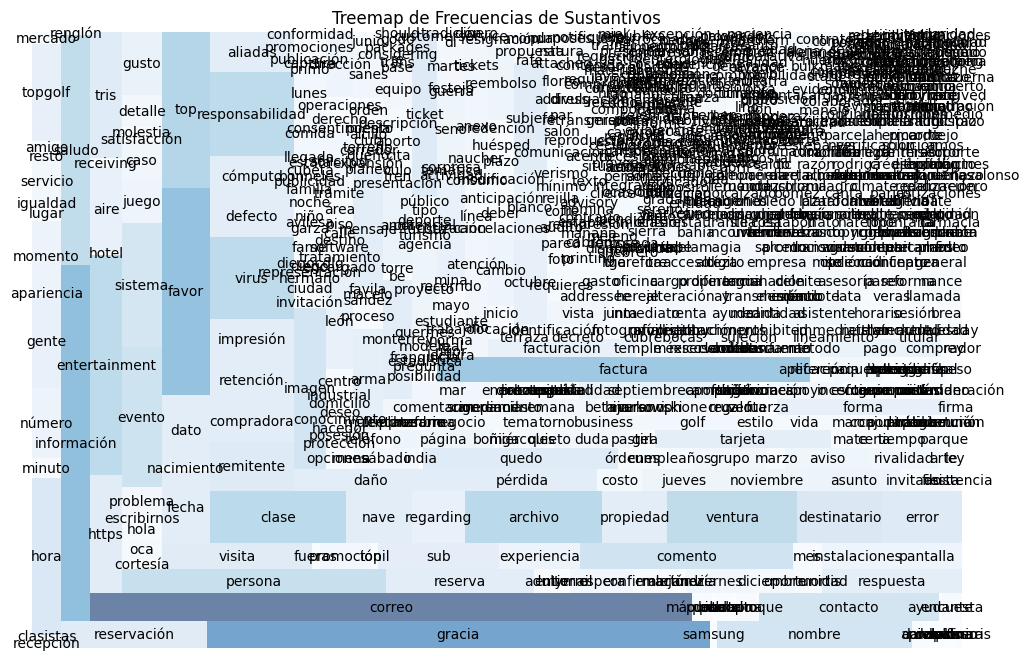

In [ ]:
# Treemap de sustantivos
plot_treemap(noun_freq, 'Treemap de Frecuencias de Sustantivos')

In [ ]:
# Función para visualizar un Word Cloud
def plot_wordcloud(freq_dict, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

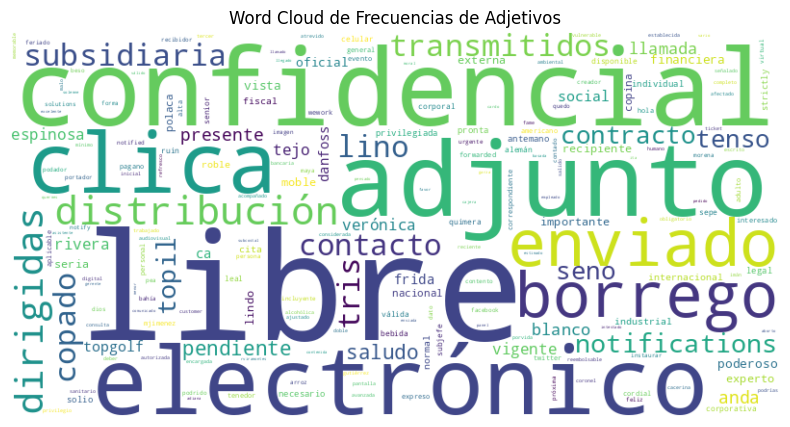

In [ ]:
# Word Cloud de adjetivos
plot_wordcloud(adjective_freq, 'Word Cloud de Frecuencias de Adjetivos')

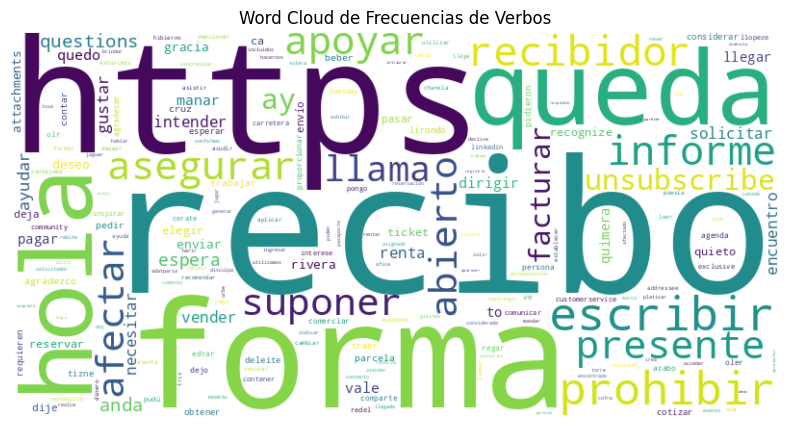

In [ ]:
# Word Cloud de verbos
plot_wordcloud(verb_freq, 'Word Cloud de Frecuencias de Verbos')

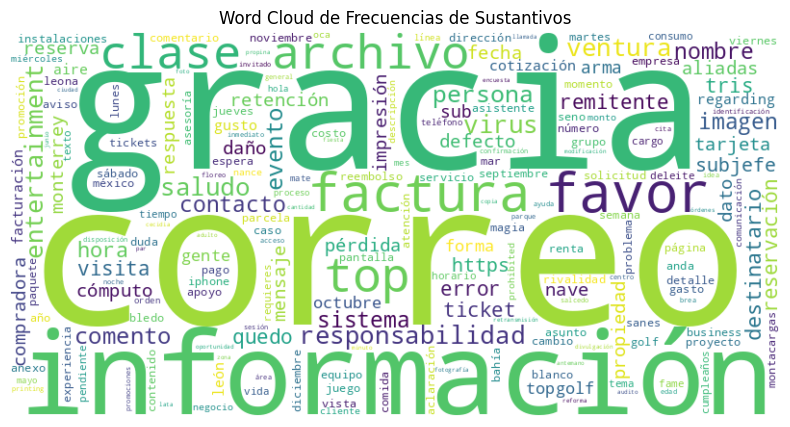

In [ ]:
# Word Cloud de sustantivos
plot_wordcloud(noun_freq, 'Word Cloud de Frecuencias de Sustantivos')

In [ ]:
# Eliminar filas con mensajes vacíos (NaN)
df = df.dropna(subset=['message'])

# Vectorización de los mensajes utilizando TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['message'])

In [ ]:
# Aplicación del algoritmo k-means
num_clusters = 5  # Define el número de clusters que deseas obtener
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Análisis de los resultados
cluster_centers = kmeans.cluster_centers_
terms = vectorizer.get_feature_names_out()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Mostrar los términos más importantes de cada cluster
for i in range(num_clusters):
    print(f"\nCluster {i + 1}:")
    cluster_terms = [terms[ind] for ind in cluster_centers[i].argsort()[-10:][::-1]]
    print(cluster_terms)


Cluster 1:
['style', 'width', 'important', 'color', 'font', 'td', 'table', 'border', 'height', 'tr']

Cluster 2:
['group', 'com', 'mailchimp', 'groups', 'google', 'https', 'messages', 'spam', 'subject', 'pendmsg']

Cluster 3:
['decode', 'unable', 'utf', 'órdenes', 'dia', 'desde', 'destinatario', 'detectors', 'device', 'digital']

Cluster 4:
['com', 'email', 'sns', 'topic', 'aws', 'west', 'comments', 'contact', 'unsubscribe', 'mx']

Cluster 5:
['la', 'en', 'el', 'que', 'para', 'com', 'por', 'mi', 'su', 'una']


In [ ]:
# Análisis estadístico de cada cluster
cluster_stats = df.groupby('cluster').describe()
print("\nEstadísticas de cada cluster:")
print(cluster_stats)


Estadísticas de cada cluster:
        internal_email_dummy                                             
                       count      mean       std  min  25%  50%  75%  max
cluster                                                                  
0                      283.0  0.996466  0.059444  0.0  1.0  1.0  1.0  1.0
1                      441.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0
2                     1010.0  0.999010  0.031466  0.0  1.0  1.0  1.0  1.0
3                     1698.0  0.986455  0.115628  0.0  1.0  1.0  1.0  1.0
4                     2766.0  0.930947  0.253590  0.0  1.0  1.0  1.0  1.0


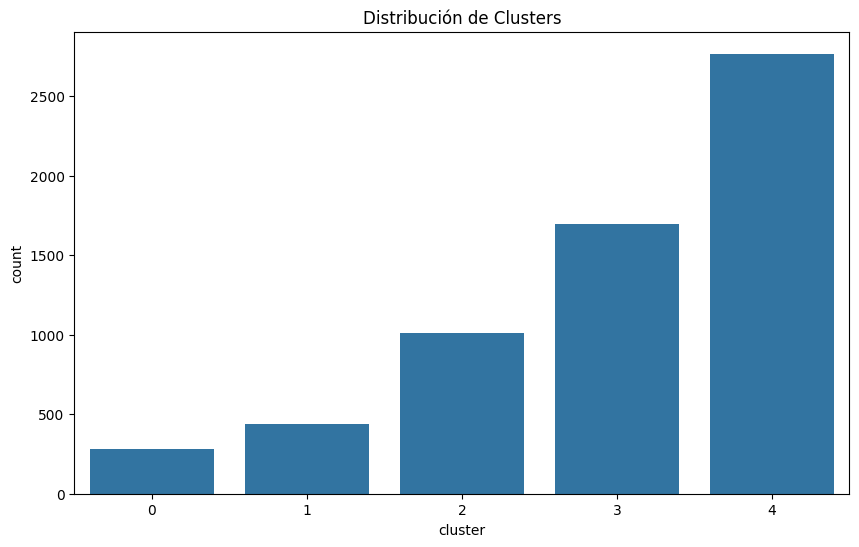

In [ ]:
# Visualización de la distribución de clusters

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cluster')
plt.title('Distribución de Clusters')
plt.show()


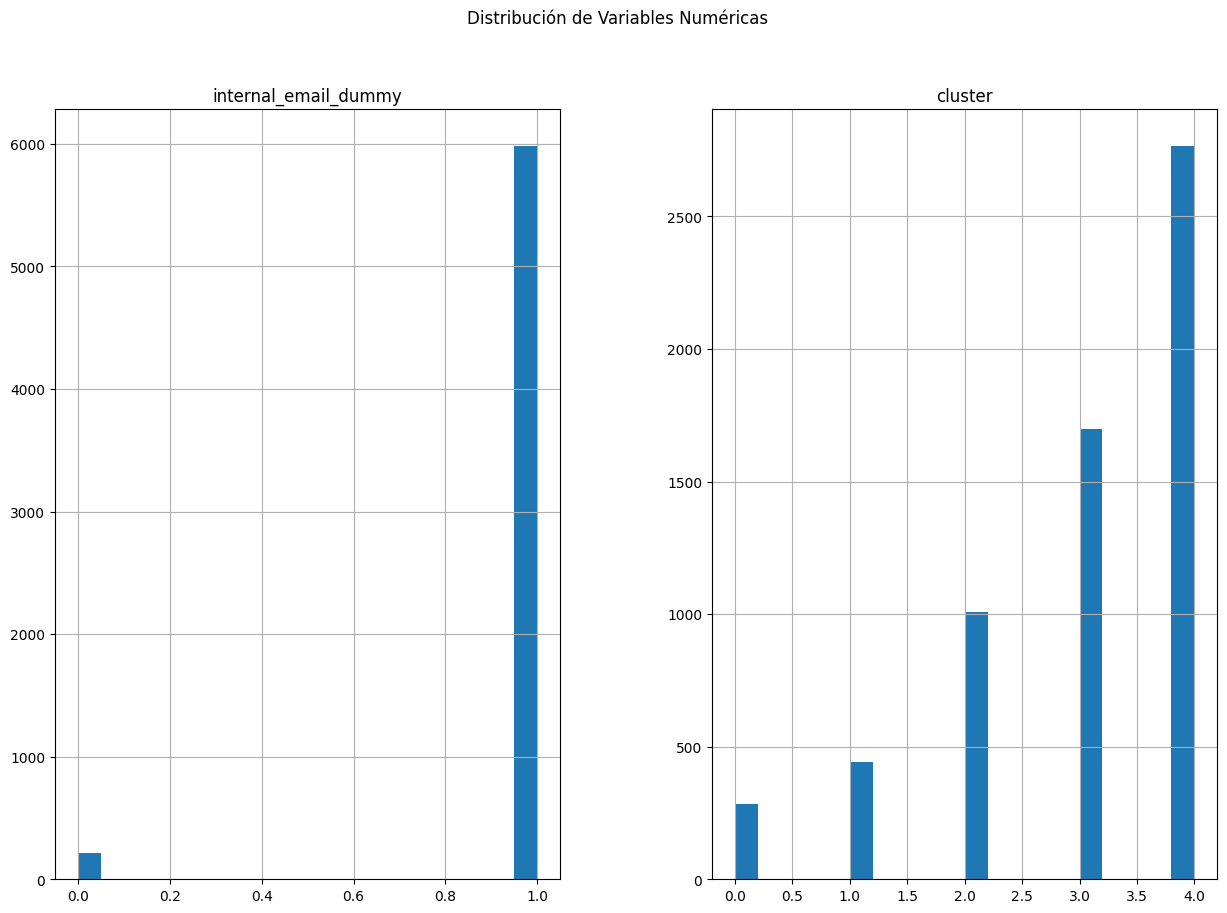

In [ ]:
# Visualización de histogramas para las variables numéricas
numerical_variables = df.select_dtypes(include=np.number).columns
df[numerical_variables].hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribución de Variables Numéricas')
plt.show()

Asimetría de cada variable:
internal_email_dummy   -5.073757
cluster                -1.029858
dtype: float64


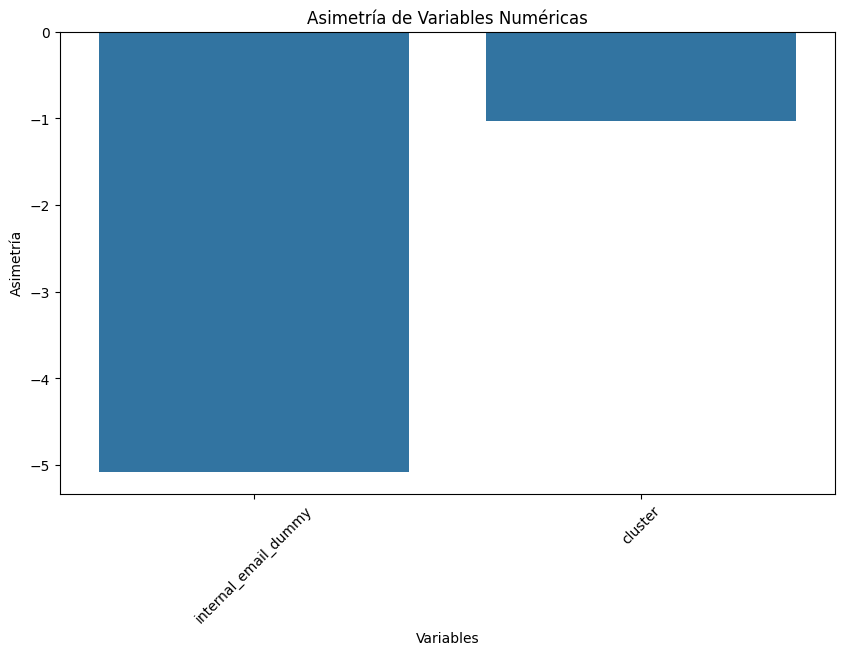

In [ ]:
# Cálculo de la asimetría para cada variable numérica
skewness = df[numerical_variables].apply(lambda x: x.skew())
print("Asimetría de cada variable:")
print(skewness)

# Visualización de la asimetría
plt.figure(figsize=(10, 6))
sns.barplot(x=skewness.index, y=skewness.values)
plt.title('Asimetría de Variables Numéricas')
plt.xlabel('Variables')
plt.ylabel('Asimetría')
plt.xticks(rotation=45)
plt.show()


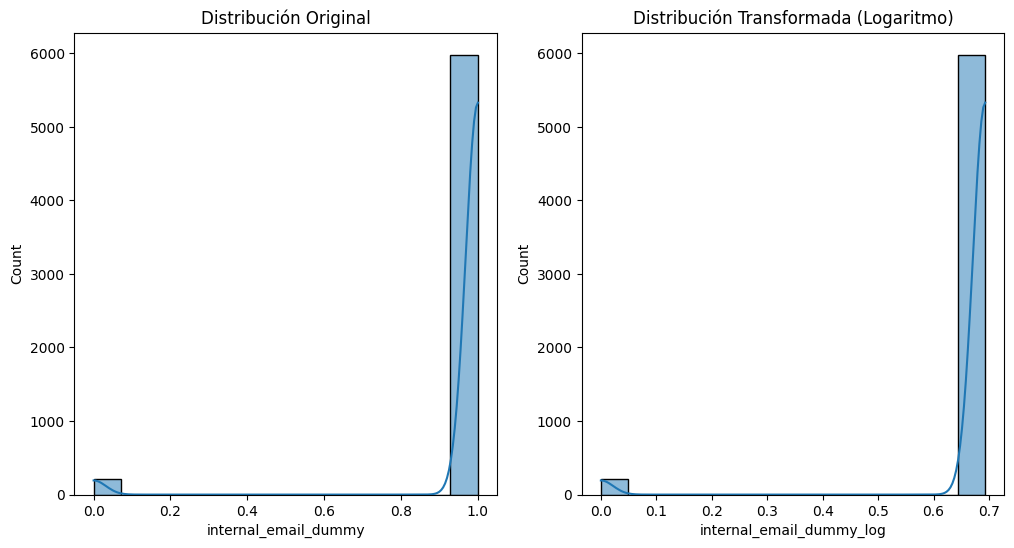

In [ ]:
# Se aplica transformación no lineal
# Aplicar logaritmo a la variable
df['internal_email_dummy_log'] = np.log1p(df['internal_email_dummy'])

# Visualizar la distribución original y la transformada
plt.figure(figsize=(12, 6))

# Distribución original
plt.subplot(1, 2, 1)
sns.histplot(df['internal_email_dummy'], kde=True)
plt.title('Distribución Original')

# Distribución transformada
plt.subplot(1, 2, 2)
sns.histplot(df['internal_email_dummy_log'], kde=True)
plt.title('Distribución Transformada (Logaritmo)')

plt.show()


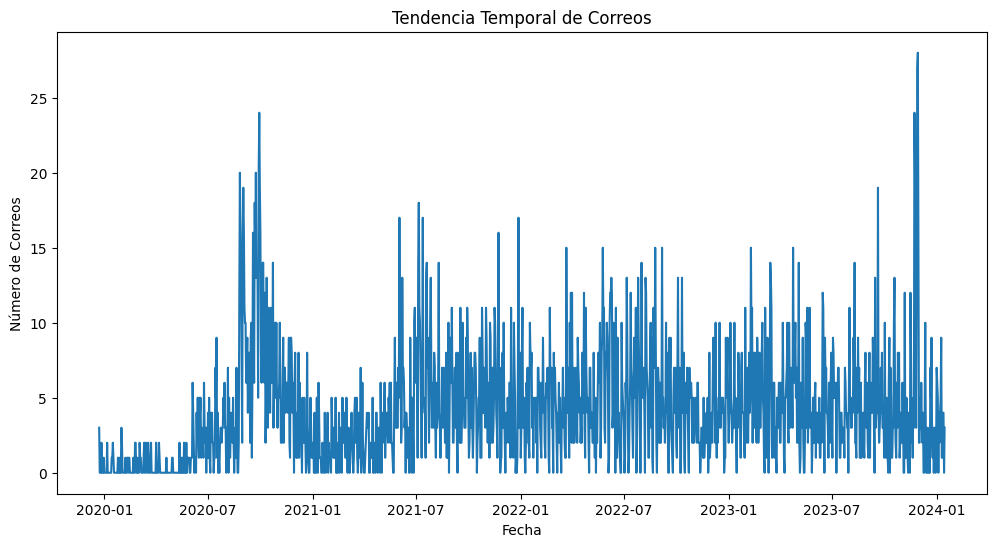

In [ ]:
# Identificar tendencias temporales y visualizar los datos a lo largo del tiempo
df['date'] = pd.to_datetime(df['date'], utc=True)

# Agrupar por fecha y contar el número de correos por día
daily_count = df.resample('D', on='date').size()

# Visualizar la serie temporal
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_count)
plt.title('Tendencia Temporal de Correos')
plt.xlabel('Fecha')
plt.ylabel('Número de Correos')
plt.show()


<ipython-input-56-3501eb2911e6>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


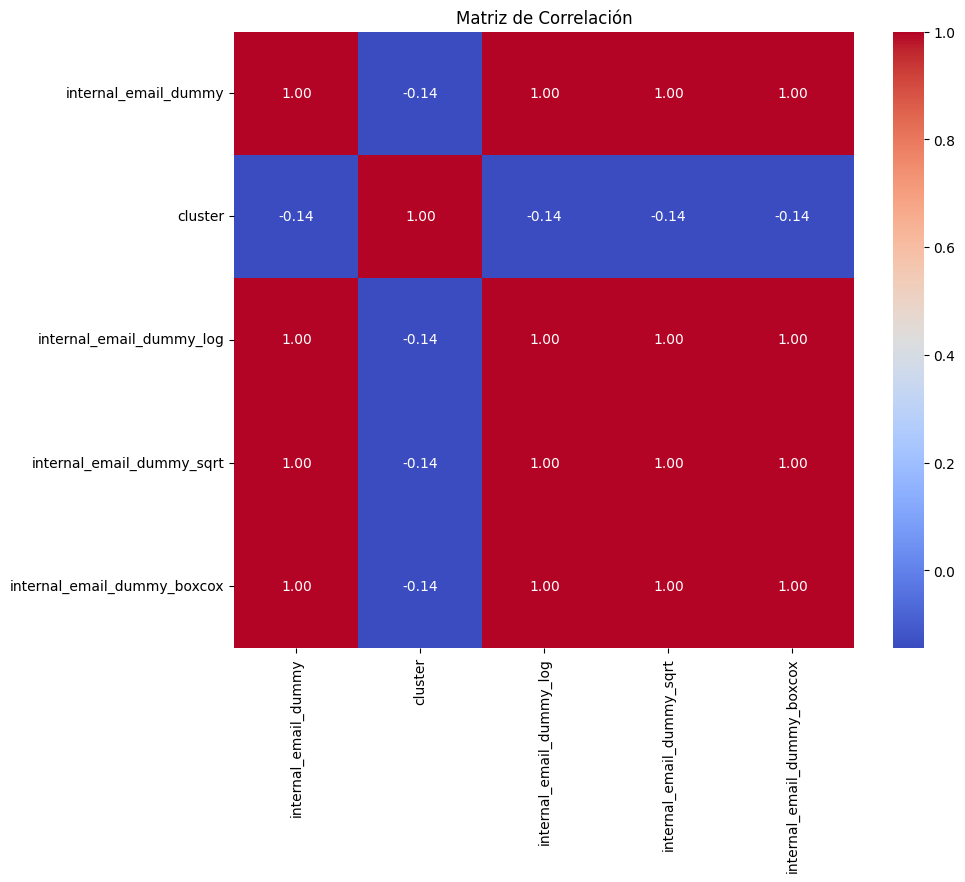

In [ ]:
# Calcular la matriz de correlación
correlation_matrix = df.corr()

# Crear un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


## Segunda iteración del estudio considerando 4 bases de datos

#### Bases de datos:
* Topgolf
* Acuario Inbursa 1
* Acuario Inbursa 2
* Acuario del Bajío

#### Importación de librerías

In [ ]:
import pandas as pd
import numpy as np
import mailbox
from email.utils import parsedate_to_datetime
import re
import glob

**** Código para extraer los correos dentro de todas las bases de datos

In [ ]:
def decodeErrorHandle(message):
    try:
        messageOut = message.get_payload(decode=True).decode()
    except UnicodeDecodeError:
        messageOut = 'Unable to decode UTF-8'
    return messageOut


def process_mbox(file_path, your_email):
    mbox = mailbox.mbox(file_path)
    email_details = []

    for msg in mbox:
        email_dict = {}

        # Determine if the email is 'Sent' or 'Received'
        sender = msg.get('From')
        #email_dict['sent_or_receive'] = 'Sent' if sender and your_email in sender else 'Received'

        # Email address of the sender or receiver
        email_dict['email_address'] = msg.get('To')

        # Message body
        if msg.is_multipart():
            for part in msg.walk():
                if part.get_content_type() == 'text/plain':
                    email_dict['message'] = decodeErrorHandle(part)
                    break
        else:
            email_dict['message'] = decodeErrorHandle(msg)

        # Date
        date = parsedate_to_datetime(msg.get('Date'))
        email_dict['date'] = date

        email_details.append(email_dict)

    return email_details


In [ ]:
# Get al emails in one list of dictionaries
outLists = []
file_names = glob.glob('*.mbox')
for file_name in file_names:
    print(file_name)
    emails = process_mbox(file_name, 'topgolf@inmomentfeedback.com')
    outLists = outLists + emails

Topgolf.mbox
Inbursa_3.mbox
AcuariodelBajio.mbox
Inbursa_1.mbox


In [ ]:
len(emails), type(emails)

(26008, list)

In [ ]:
df = pd.DataFrame(emails)
df.describe()

email_address                 message  \
count                            25963                   25668   
unique                            3563                   21435   
top     contacto@acuarioinbursa.com.mx  Unable to decode UTF-8   
freq                              9537                    2270   

                             date  
count                       26008  
unique                      25586  
top     2023-09-11 12:29:37+00:00  
freq                            6

#### Mensajes con errores de decodificación

In [ ]:
# Messages with errors to decode
df[df.message == 'Unable to decode UTF-8'].count()

email_address    2262
message          2270
date             2270
dtype: int64

#### Código para extraer la dirección de email del cliente

In [ ]:
# Format email addresses to filter to only one address

# Regex pattern for matching email addresses
email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'

def find_email(text):
    if text is None:
        return None
    listEmails = re.findall(email_pattern, text)
    if listEmails is None:
        return text
    if len(listEmails) == 0:
        return listEmails
    while listEmails:
        mail = listEmails.pop()
        if "topgolf.com" not in mail and 'acuarioinbursa':
            return mail
    return mail

In [ ]:
# Apply filter of emails on email
df['clean_email'] = df['email_address'].apply(lambda x: find_email(str(x)))

In [ ]:
list_cleaned = [
    x for x in df['clean_email'].astype(str).unique()
    if 'topgolf' not in x.lower() and 'acuarioinbursa' not in x.lower()
]
list_cleaned

['omarhernandezmd705@gmail.com',
 'david_vera29@yahoo.com.mx',
 'mike_azulcrema@hotmail.com',
 'alicecardenas94@gmail.com',
 'fugaz880@gmail.com',
 'lettnazor@yahoo.com',
 'danielasiles09@gmail.com',
 'martinez.rangel.garet@gmail.com',
 'ssolano.sharon@gmail.com',
 'lac.sjleon@gmail.com',
 'fernandezsolismaelena@gmail.com',
 'rchavez@venturae.com.mx',
 'jorgenavarrete643@gmail.com',
 'josuepuc9899@gmail.com',
 'michellesoto@hotmail.com',
 'hiromicr2605@gmail.com',
 'jnavach22@hotmail.com',
 'hugosor318@gmail.com',
 'mau.fdez@gmail.com',
 'kar041100@gmail.com',
 'mari_fersaar@hotmail.com',
 '[]',
 'armandoaysa@gmail.com',
 'roberttojamtiempos@gmail.com',
 'islaslopezmarlene29@gmail.com',
 'liset.delcarpio@gmail.com',
 'alanis0308@outlook.com',
 'chentehertobi@gmail.com',
 'canelramirezjenyalin@gmail.com',
 'marizu.vazro@gmail.com',
 'rociomestas1@gmail.com',
 'kevinpimram@gmail.com',
 'daniahdom@gmail.com',
 'ct2250852@gmail.com',
 'angeleshguzman28@gmail.com',
 'miguel800625@gmail.com'

### Código para extraer contenido de texto de los clientes

In [ ]:
# Function to extract the lines for the customer input
def extract_customer_text(text, line_start_symnbol='>'):
    pattern = rf'^{line_start_symnbol}.*$'
    lines_out = re.findall(pattern, text, re.MULTILINE)
    return lines_out

In [ ]:
df['customer_text'] = df['message'].apply(lambda x: extract_customer_text(x) if type(x) is not float else '')
df['customer_text'] = df['customer_text'].apply(lambda x: '' if type(x) == list and len(x) == 0 else x)

In [ ]:
df

email_address  \
0                         contacto@acuarioinbursa.com.mx   
1                         contacto@acuarioinbursa.com.mx   
2                         contacto@acuarioinbursa.com.mx   
3                         contacto@acuarioinbursa.com.mx   
4                       <contacto@acuarioinbursa.com.mx>   
...                                                  ...   
26003                                danrr.998@gmail.com   
26004                     contacto@acuarioinbursa.com.mx   
26005                     contacto@acuarioinbursa.com.mx   
26006  Ana Sofia Ramirez Luna <a.ramirez@acuarioinbur...   
26007  Acuario Inbursa Contacto <contacto@acuarioinbu...   

                                                 message  \
0                     [Landbot] New Message Notification   
1                     [Landbot] New Message Notification   
2                     [Landbot] New Message Notification   
3                     [Landbot] New Message Notification   
4      Gracias a su trabajo en serie ¿Y Tú, Tú Qué Va...   
...                                                  ...   
26003  Hola, te hago llegar tu fotografía digital. Bu...   
26004  \r\n** El mensaje no se ha podido enviar **\r\...   
26005  \r\n** No se ha encontrado la dirección **\r\n...   
26006  Buen día Sofi y Memo, me apoyan con esta solic...   
26007  Hola!\r\nNuestra hora de entrada fue aproximad...   

                            date                     clean_email  \
0      2024-01-15 18:58:32+00:00  contacto@acuarioinbursa.com.mx   
1      2024-01-15 18:57:39+00:00  contacto@acuarioinbursa.com.mx   
2      2024-01-15 18:54:08+00:00  contacto@acuarioinbursa.com.mx   
3      2024-01-15 18:53:57+00:00  contacto@acuarioinbursa.com.mx   
4      2024-01-15 18:20:55+00:00  contacto@acuarioinbursa.com.mx   
...                          ...                             ...   
26003  2022-03-24 13:27:41-06:00             danrr.998@gmail.com   
26004  2022-03-24 17:26:53-07:00  contacto@acuarioinbursa.com.mx   
26005  2022-03-24 09:35:16-07:00  contacto@acuarioinbursa.com.mx   
26006  2022-03-24 11:57:04-06:00   g.amaya@acuarioinbursa.com.mx   
26007  2022-03-24 02:21:02-05:00  contacto@acuarioinbursa.com.mx   

                                           customer_text  
0                                                         
1                                                         
2                                                         
3                                                         
4                                                         
...                                                  ...  
26003  [>\r, >\r, >\r, >\r, >\r, >\r, >\r, >\r, > ---...  
26004                                                     
26005                                                     
26006  [> Buenas noches con mucho gusto damos seguimi...  
26007  [> Buenas noches con mucho gusto damos seguimi...  

[26008 rows x 5 columns]

In [ ]:
df_messages = df[df['customer_text'] != ''].copy()
df_messages

email_address  \
20     =?UTF-8?Q?Omar_Hern=C3=A1ndez?= <omarhernandez...   
27     alfonso david canales vera <david_vera29@yahoo...   
29     alfonso david canales vera <david_vera29@yahoo...   
31     celso daniel galeana martinez <mike_azulcrema@...   
32     Alicia Cardenas Cuevas <alicecardenas94@gmail....   
...                                                  ...   
25996  Acuario <contacto@acuarioinbursa.com.mx>, tino...   
25999           Acuario <contacto@acuarioinbursa.com.mx>   
26003                                danrr.998@gmail.com   
26006  Ana Sofia Ramirez Luna <a.ramirez@acuarioinbur...   
26007  Acuario Inbursa Contacto <contacto@acuarioinbu...   

                                                 message  \
20     Buen día, cómo le podemos asistir?\r\n\r\nSegu...   
27     Buenas tardes, mucho le agradeceremos revise s...   
29     Buenas tardes, con gusto podemos agendar su vi...   
31     Excelente noticia!!\r\n¡¡Los esperamos!!\r\n\r...   
32     Buenas tardes, no es necesario presentar la ta...   
...                                                  ...   
25996  El El vie, 25 de marzo de 2022 a la(s) 8:15, A...   
25999  Buen día\r\n\r\nConfirmo de recibido sin embar...   
26003  Hola, te hago llegar tu fotografía digital. Bu...   
26006  Buen día Sofi y Memo, me apoyan con esta solic...   
26007  Hola!\r\nNuestra hora de entrada fue aproximad...   

                            date                     clean_email  \
20     2024-01-14 10:56:15-06:00    omarhernandezmd705@gmail.com   
27     2024-01-13 15:18:52-06:00       david_vera29@yahoo.com.mx   
29     2024-01-13 14:27:52-06:00       david_vera29@yahoo.com.mx   
31     2024-01-13 13:59:01-06:00      mike_azulcrema@hotmail.com   
32     2024-01-13 13:58:38-06:00       alicecardenas94@gmail.com   
...                          ...                             ...   
25996  2022-03-25 13:55:30-06:00       tino_acosta_m@hotmail.com   
25999  2022-03-24 13:17:23-06:00  contacto@acuarioinbursa.com.mx   
26003  2022-03-24 13:27:41-06:00             danrr.998@gmail.com   
26006  2022-03-24 11:57:04-06:00   g.amaya@acuarioinbursa.com.mx   
26007  2022-03-24 02:21:02-05:00  contacto@acuarioinbursa.com.mx   

                                           customer_text  
20     [>\r, > El mié., 10 de enero de 2024 9:11 a. m...  
27     [> buenas tardes\r, >\r, > solicito para el dí...  
29     [> ACUARIO INBURSA\r, > A¨TN A CLIENTES\r, >\r...  
31     [>\r, > Perfecto ya los tengo en mi bandeja! M...  
32     [> Hola buenas tardes, tengo una duda respecto...  
...                                                  ...  
25996  [> [image: Acuario Inbursa]\r, > Gracias por e...  
25999  [> [image: Acuario Inbursa]\r, > Gracias por e...  
26003  [>\r, >\r, >\r, >\r, >\r, >\r, >\r, >\r, > ---...  
26006  [> Buenas noches con mucho gusto damos seguimi...  
26007  [> Buenas noches con mucho gusto damos seguimi...  

[8346 rows x 5 columns]

### Código para procesar las paralbras en los mensajes y obtener gráfica de pareto

In [ ]:
# Importar librerías
from spellchecker import SpellChecker
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import nltk

from joblib import Parallel, delayed
from tqdm import tqdm
import pandas as pd
import ast
import seaborn as sns

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/javiergranados/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javiergranados/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
spell = SpellChecker(language='es')

def process_text(text_in_list, spell_check=False, delete_unrecognized_words=False):
    # Extract the text by joining the text within list elements
    text = '\n'.join(text_in_list)
    # Get words from customer text
    pattern = re.compile(r'[^\w\s\d]\_', re.UNICODE)
    # Remove unwanted characters
    filtered_text = pattern.sub('', text)
    # Spell correction
    #spell = SpellChecker(language='es')
    words = word_tokenize(filtered_text)
    # Use spell checker to homologate words, and leave unrecognized words
    if spell_check:
        corrected_words = []
        for word in words:
            if word.isalpha():
                if spell.correction(word) is not None:
                    corrected_words.append(spell.correction(word))
                elif delete_unrecognized_words and spell.correction(word) is None:
                    pass
                else:
                    corrected_words.append(word)

    else:
        corrected_words = [word for word in words if word.isalpha()]
    return corrected_words

#### El siguiente código está comentado parcialmente pues el procesar todos los mensajes lleva al rededor de 5 horas en nuestras computadoreas personales. En su lugar está activo código que lee un archivo CSV con la información ya procesada.  

In [ ]:
# Parallel processing using joblib
#results = Parallel(n_jobs=-1)(delayed(process_text)(row['customer_text'], spell_check=True, delete_unrecognized_words=True)
#                              for _, row in tqdm(df_messages.iterrows(), total=len(df_messages)))

#df_messages['customer_filtered_corrected_text_spellcheck_worddelete'] = results

df_messages = pd.read_csv('messages_processed.csv')

In [ ]:
df_messages

Unnamed: 0.1  Unnamed: 0  \
0                0          20   
1                1          27   
2                2          29   
3                3          31   
4                4          32   
...            ...         ...   
8341          8341       25996   
8342          8342       25999   
8343          8343       26003   
8344          8344       26006   
8345          8345       26007   

                                          email_address  \
0     =?UTF-8?Q?Omar_Hern=C3=A1ndez?= <omarhernandez...   
1     alfonso david canales vera <david_vera29@yahoo...   
2     alfonso david canales vera <david_vera29@yahoo...   
3     celso daniel galeana martinez <mike_azulcrema@...   
4     Alicia Cardenas Cuevas <alicecardenas94@gmail....   
...                                                 ...   
8341  Acuario <contacto@acuarioinbursa.com.mx>, tino...   
8342           Acuario <contacto@acuarioinbursa.com.mx>   
8343                                danrr.998@gmail.com   
8344  Ana Sofia Ramirez Luna <a.ramirez@acuarioinbur...   
8345  Acuario Inbursa Contacto <contacto@acuarioinbu...   

                                                message  \
0     Buen día, cómo le podemos asistir?\r\n\r\nSegu...   
1     Buenas tardes, mucho le agradeceremos revise s...   
2     Buenas tardes, con gusto podemos agendar su vi...   
3     Excelente noticia!!\r\n¡¡Los esperamos!!\r\n\r...   
4     Buenas tardes, no es necesario presentar la ta...   
...                                                 ...   
8341  El El vie, 25 de marzo de 2022 a la(s) 8:15, A...   
8342  Buen día\r\n\r\nConfirmo de recibido sin embar...   
8343  Hola, te hago llegar tu fotografía digital. Bu...   
8344  Buen día Sofi y Memo, me apoyan con esta solic...   
8345  Hola!\r\nNuestra hora de entrada fue aproximad...   

                           date                     clean_email  \
0     2024-01-14 10:56:15-06:00    omarhernandezmd705@gmail.com   
1     2024-01-13 15:18:52-06:00       david_vera29@yahoo.com.mx   
2     2024-01-13 14:27:52-06:00       david_vera29@yahoo.com.mx   
3     2024-01-13 13:59:01-06:00      mike_azulcrema@hotmail.com   
4     2024-01-13 13:58:38-06:00       alicecardenas94@gmail.com   
...                         ...                             ...   
8341  2022-03-25 13:55:30-06:00       tino_acosta_m@hotmail.com   
8342  2022-03-24 13:17:23-06:00  contacto@acuarioinbursa.com.mx   
8343  2022-03-24 13:27:41-06:00             danrr.998@gmail.com   
8344  2022-03-24 11:57:04-06:00   g.amaya@acuarioinbursa.com.mx   
8345  2022-03-24 02:21:02-05:00  contacto@acuarioinbursa.com.mx   

                                          customer_text  \
0     ['>\r', '> El mié., 10 de enero de 2024 9:11 a...   
1     ['> buenas tardes\r', '>\r', '> solicito para ...   
2     ['> ACUARIO INBURSA\r', '> A¨TN A CLIENTES\r',...   
3     ['>\r', '> Perfecto ya los tengo en mi bandeja...   
4     ['> Hola buenas tardes, tengo una duda respect...   
...                                                 ...   
8341  ['> [image: Acuario Inbursa]\r', '> Gracias po...   
8342  ['> [image: Acuario Inbursa]\r', '> Gracias po...   
8343  ['>\r', '>\r', '>\r', '>\r', '>\r', '>\r', '>\...   
8344  ['> Buenas noches con mucho gusto damos seguim...   
8345  ['> Buenas noches con mucho gusto damos seguim...   

     customer_filtered_corrected_text_spellcheck_worddelete  
0     ['El', 'de', 'enero', 'de', 'Acuario', 'contac...      
1     ['buena', 'tarde', 'solícito', 'para', 'el', '...      
2     ['ACUARIO', 'incursa', 'A', 'cliente', 'Por', ...      
3     ['Perfecto', 'ya', 'los', 'tenso', 'en', 'mi',...      
4     ['Hola', 'buena', 'tarde', 'tenso', 'una', 'du...      
...                                                 ...      
8341  ['imagen', 'Acuario', 'incursa', 'gracia', 'po...      
8342  ['imagen', 'Acuario', 'incursa', 'gracia', 'po...      
8343  ['mensaje', 'De', 'Acuario', 'incursa', 'Conta...      
8344  ['buena', 'noche', 'con', 'mucho', 'gus

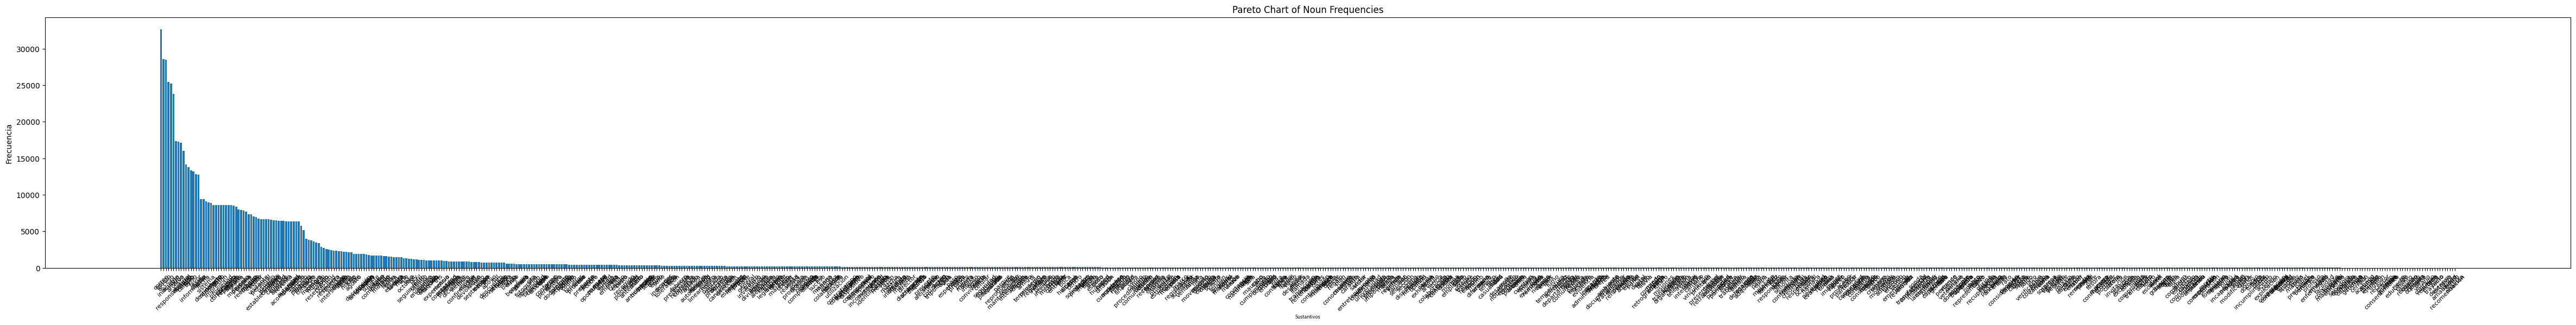

In [ ]:
import spacy
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Load the Spanish NLP model
nlp = spacy.load('es_core_news_sm')
sw1 = ['de', 'el', 'del', 'al', 'en', 'que', 'por', 'esto', 'este', 'su']

# Function to process text and categorize words
def categorize_words(texts, additional_stopwords=None):
    adjectives = []
    verbs = []
    nouns = []

    # Convert the custom stopwords list to a set for faster searching
    custom_stopwords = set(additional_stopwords or [])

    # Combine custom stopwords with the built-in SpaCy stopwords
    combined_stopwords = custom_stopwords.union(nlp.Defaults.stop_words)

    # Process each text
    for doc in nlp.pipe(texts, disable=["ner", "parser"]):
        # Convert to lowercase and categorize
        for token in doc:
            # Check if it's not a stop word (either custom or default) and is alphabetical
            if token.text.lower() not in combined_stopwords and token.is_alpha:
                lower_word = token.text.lower()
                if token.pos_ == 'ADJ':  # Adjective
                    adjectives.append(lower_word)
                elif token.pos_ == 'VERB':  # Verb
                    verbs.append(lower_word)
                elif token.pos_ == 'NOUN':  # Noun
                    nouns.append(lower_word)

    return adjectives, verbs, nouns

# We need to join the lists into a single text string for each row
#texts = [' '.join(words_list).lower() for words_list in df_messages['customer_filtered_corrected_text_spellcheck_worddelete']]
texts = [' '.join(ast.literal_eval(words_list)).lower() for words_list in df_messages['customer_filtered_corrected_text_spellcheck_worddelete']]

# Categorize words
adjectives, verbs, nouns = categorize_words(texts, additional_stopwords=sw1)

# Count the frequency of each word category
adjective_freq = Counter(adjectives)
verb_freq = Counter(verbs)
noun_freq = Counter(nouns)


sorted_nouns = dict(sorted(noun_freq.items(), key=lambda item: item[1], reverse=True))
num_words_to_display = len(sorted_nouns) // 4  # Display only the first half
plt.figure(figsize=(60, 6))
plt.xlabel('Palabras', fontsize='xx-small')
plt.bar(list(sorted_nouns.keys())[:num_words_to_display], list(sorted_nouns.values())[:num_words_to_display])
plt.xlabel('Sustantivos')
plt.ylabel('Frecuencia')
plt.xticks(rotation=45, fontsize=8)
plt.title('Pareto Chart of Noun Frequencies')
plt.show()


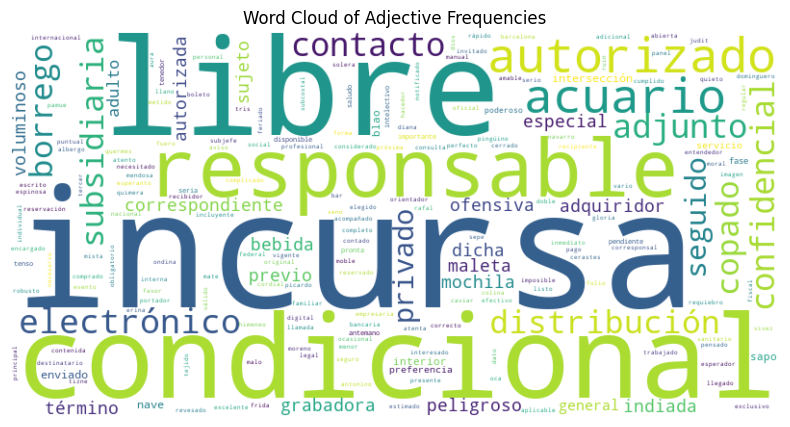

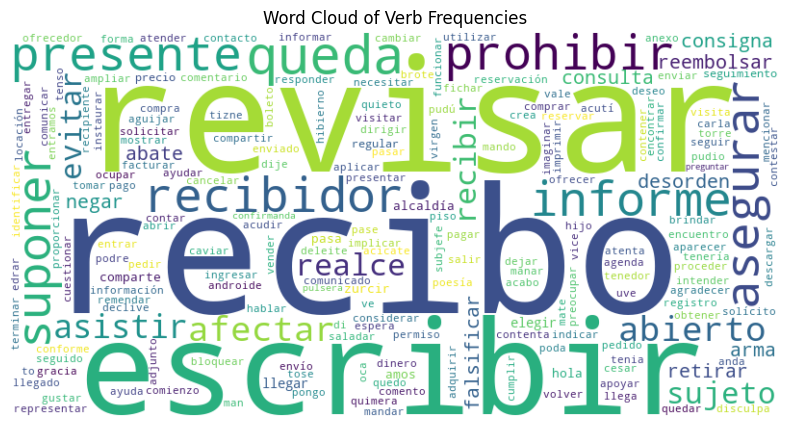

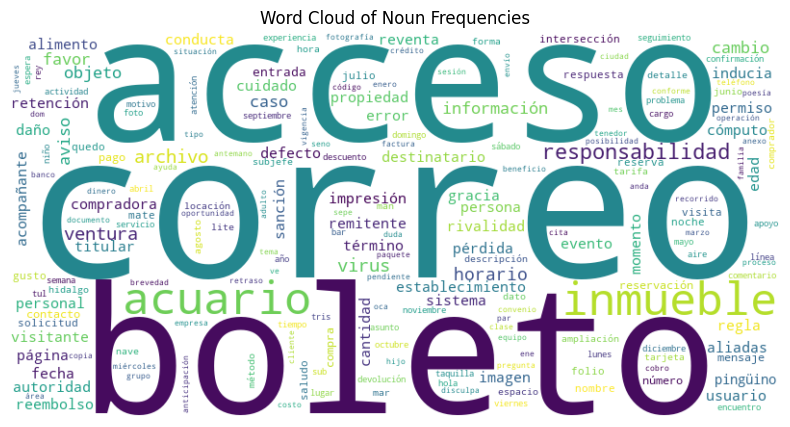

In [ ]:
from wordcloud import WordCloud

# Function to plot a word cloud for the given frequency dictionary
def plot_wordcloud(freq_dict, title):
    # Create a word cloud from the frequencies
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)

    # Plot
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Plot word clouds for each part of speech
plot_wordcloud(adjective_freq, 'Word Cloud of Adjective Frequencies')
plot_wordcloud(verb_freq, 'Word Cloud of Verb Frequencies')
plot_wordcloud(noun_freq, 'Word Cloud of Noun Frequencies')


### Las nubes de palabras nos dan una ídea del contenido en los textos que envían los clientes a los correos de contacto de los negocios de Ventura Entertainment. Para agudizar los resultados se crearán clusters con las palabras de dicha comuniación eliminando "stopwords" además de crear clusters con ngrams. Esto debe proveer suficiente información sobre las intenciones de la comunicaci´no de los clientes.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
import spacy
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [ ]:
tfidf_vectorizer = TfidfVectorizer()

#texts = df_messages['customer_filtered_corrected_text_spellcheck_worddelete'].apply(lambda word_list:' '.join(word_list))
texts = df_messages['customer_filtered_corrected_text_spellcheck_worddelete'].apply(lambda word_list:' '.join(ast.literal_eval(word_list)))

tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

#### La lista de stopwords tuvo que ser expandida según varias iteraciones del mismo proceso en las celdas siguientes.

In [ ]:
# Load SpaCy Spanish language model
nlp = spacy.load('es_core_news_sm')

# Define your additional custom stopwords as a list
additional_stopwords = ['de', 'el', 'del', 'al', 'en', 'que', 'por', 'esto', 'este', 'su', 'to', 'man', 'incursa', 'espinosa', 'tris', 'can', 'col', 'sant', 'judit', 'vivez', 'ay', 'in']

# Combine SpaCy's default stopwords with your additional stopwords
combined_stopwords = list(nlp.Defaults.stop_words.union(additional_stopwords))

# Initialize TfidfVectorizer with the combined stopwords
tfidf_vectorizer = TfidfVectorizer(stop_words=combined_stopwords)

# Convert the string representation of lists back to actual lists and then join each list into a single string
texts = df_messages['customer_filtered_corrected_text_spellcheck_worddelete'].apply(
    lambda word_list: ' '.join(ast.literal_eval(word_list))
)

# Generate TF-IDF matrix
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)


/Users/javiergranados/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


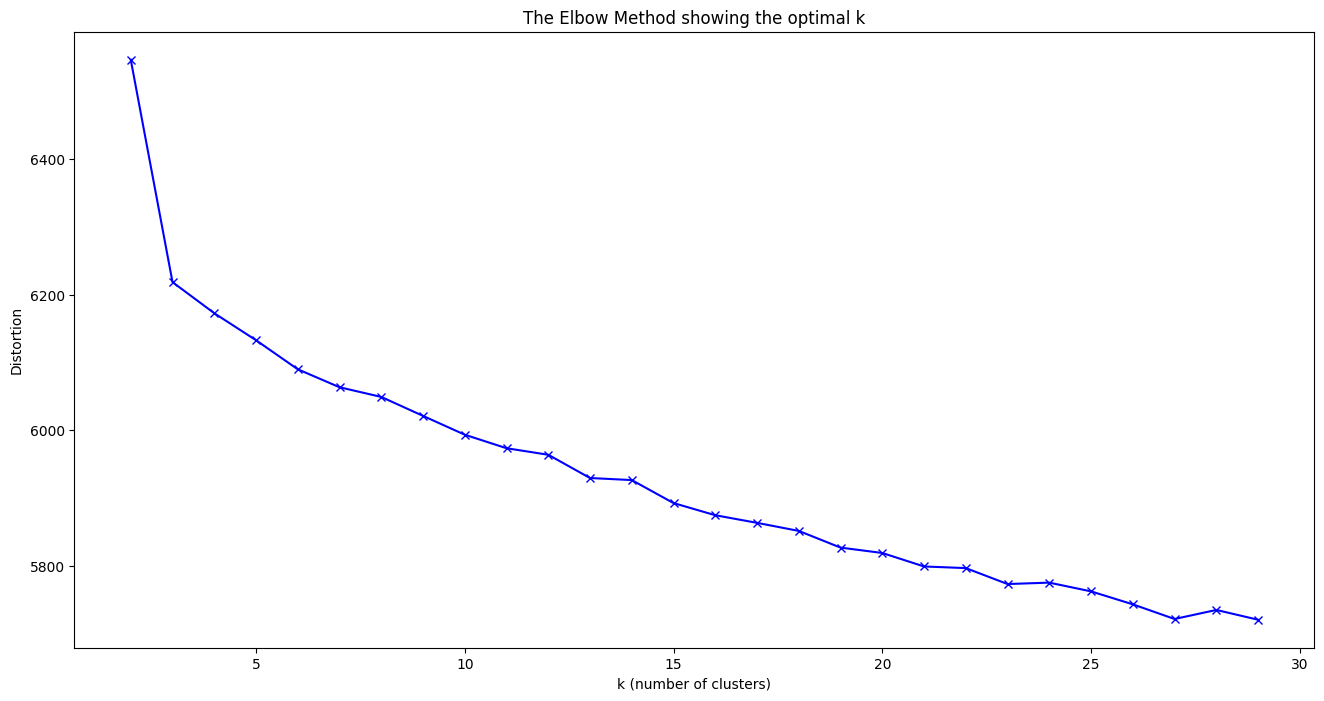

In [ ]:
# Calculate distortion for a range of number of cluster
distortions = []
K = range(2, 30)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(tfidf_matrix)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow graph
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k (number of clusters)')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### El número de clusters donde se encuentra el "codo" es de 3. Indicando por regla general el número ideal de clusters. Sin embargo la distorsión sigue reduciendose de manera lineal después de ese valor de K. Se tomó arbitrariamente el valode re 10 clusters para analizar los datos que arroja el algoritmo de kmeans.

In [ ]:
# Run KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(tfidf_matrix)

# Assign clusters to documents
clusters = kmeans.labels_

/Users/javiergranados/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
def get_top_features_cluster(tfidf_vectorizer, centroids, n_feats):
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(centroids.shape[0]):
        center_vec = centroids[i]
        sorted_terms = center_vec.argsort()[::-1]  # sort in descending order
        top_terms = [terms[index] for index in sorted_terms[:n_feats]]
        print(f"Cluster {i}: {top_terms}")

# Get the centroids
centroids = kmeans.cluster_centers_

# Display the top features for each cluster
get_top_features_cluster(tfidf_vectorizer, centroids, 10)


Cluster 0: ['contacto', 'mensaje', 'saludo', 'subjefe', 'mate', 'acuario', 'convenio', 'fichar', 'comparte', 'seguido']
Cluster 1: ['inmueble', 'acceso', 'acuario', 'adulto', 'boleto', 'responsabilidad', 'sujeto', 'correo', 'objeto', 'autorizado']
Cluster 2: ['anda', 'mensaje', 'aire', 'intender', 'recipiente', 'clase', 'vender', 'méxico', 'oír', 'copia']
Cluster 3: ['correo', 'recibo', 'ventura', 'responsabilidad', 'libre', 'virus', 'archivo', 'acuario', 'contacto', 'escribir']
Cluster 4: ['inmueble', 'acceso', 'objeto', 'autorizado', 'boleto', 'responsable', 'sujeto', 'término', 'condicional', 'aviso']
Cluster 5: ['correo', 'libre', 'ventura', 'virus', 'responsabilidad', 'recibo', 'archivo', 'escribir', 'acuario', 'contacto']
Cluster 6: ['pingüino', 'entrada', 'hola', 'gracia', 'acuario', 'reservación', 'quimera', 'quedo', 'boleto', 'costo']
Cluster 7: ['boleto', 'compra', 'comprar', 'línea', 'enviado', 'quedo', 'correo', 'tarjeta', 'tenso', 'hola']
Cluster 8: ['foto', 'fotografía', 

### Los clusters arrojados siguen sin darnos claridad sobre las intenciones del cliete salvo por algunas palabras clave como "contacto, recibo, acceso, reservación". Por lo que el agrupar con "ngrams" es una mejor estrategia.

In [ ]:
# Initialize TfidfVectorizer with ngram_range to include bigrams and trigrams
tfidf_vectorizer = TfidfVectorizer(stop_words=combined_stopwords, ngram_range=(2, 4))

# Assuming texts is your preprocessed text data
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

In [ ]:
# Define the number of clusters
num_clusters = 11

# Initialize KMeans
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit the model
kmeans.fit(tfidf_matrix)

# Assign the clusters to each document
clusters = kmeans.labels_

In [ ]:
def get_top_features_cluster(tfidf_vectorizer, centroids, n_feats):
    terms = tfidf_vectorizer.get_feature_names_out()
    for i in range(centroids.shape[0]):
        center_vec = centroids[i]
        sorted_terms = center_vec.argsort()[::-1]  # sort in descending order
        top_terms = [terms[index] for index in sorted_terms[:n_feats]]
        print(f"Cluster {i}: {top_terms}")

# Get the centroids
centroids = kmeans.cluster_centers_

# Display the top features for each cluster
get_top_features_cluster(tfidf_vectorizer, centroids, 11)

Cluster 0: ['comprar boleto', 'seguido acuario', 'saludo mensaje', 'intersección pingüino', 'contacto contacto', 'acuario mensaje', 'seguido acuario mensaje', 'comparte correo', 'quedo atenta', 'contacto hola', 'entrada acuario']
Cluster 1: ['compra boleto', 'boleto línea', 'enviado correo', 'comprar boleto', 'compra boleto línea', 'quedo comprar', 'realce compra', 'quedo comprar boleto', 'realce compra boleto', 'número reservación', 'hola compra']
Cluster 2: ['libre virus', 'correo electrónico', 'informe remitente borrego inmediatamente', 'electrónico propiedad ventura subsidiaria', 'subsidiaria confidencial', 'subsidiaria confidencial exclusivamente', 'subsidiaria confidencial exclusivamente destinatario', 'ventura subsidiaria confidencial exclusivamente', 'información archivo correo electrónico', 'favor informe remitente borrego', 'información archivo correo']
Cluster 3: ['libre virus', 'comparte folio reserva comienzo', 'folio reserva comienzo', 'reserva comienzo', 'comparte folio 

### Código para generar chart de pareto con la cuenta de ngrams más repetidos en los centroides

In [ ]:
def get_top_ngrams_from_centroids(tfidf_vectorizer, centroids, n_top_ngrams):
    terms = tfidf_vectorizer.get_feature_names_out()
    top_ngrams = {}

    for i in range(centroids.shape[0]):
        center_vec = centroids[i]
        sorted_indices = center_vec.argsort()[::-1]  # sort in descending order
        for idx in sorted_indices[:n_top_ngrams]:
            ngram = terms[idx]
            top_ngrams[ngram] = top_ngrams.get(ngram, 0) + center_vec[idx]

    return top_ngrams

# Assuming you have your centroids from KMeans and tfidf_vectorizer
top_ngrams = get_top_ngrams_from_centroids(tfidf_vectorizer, kmeans.cluster_centers_, 10)


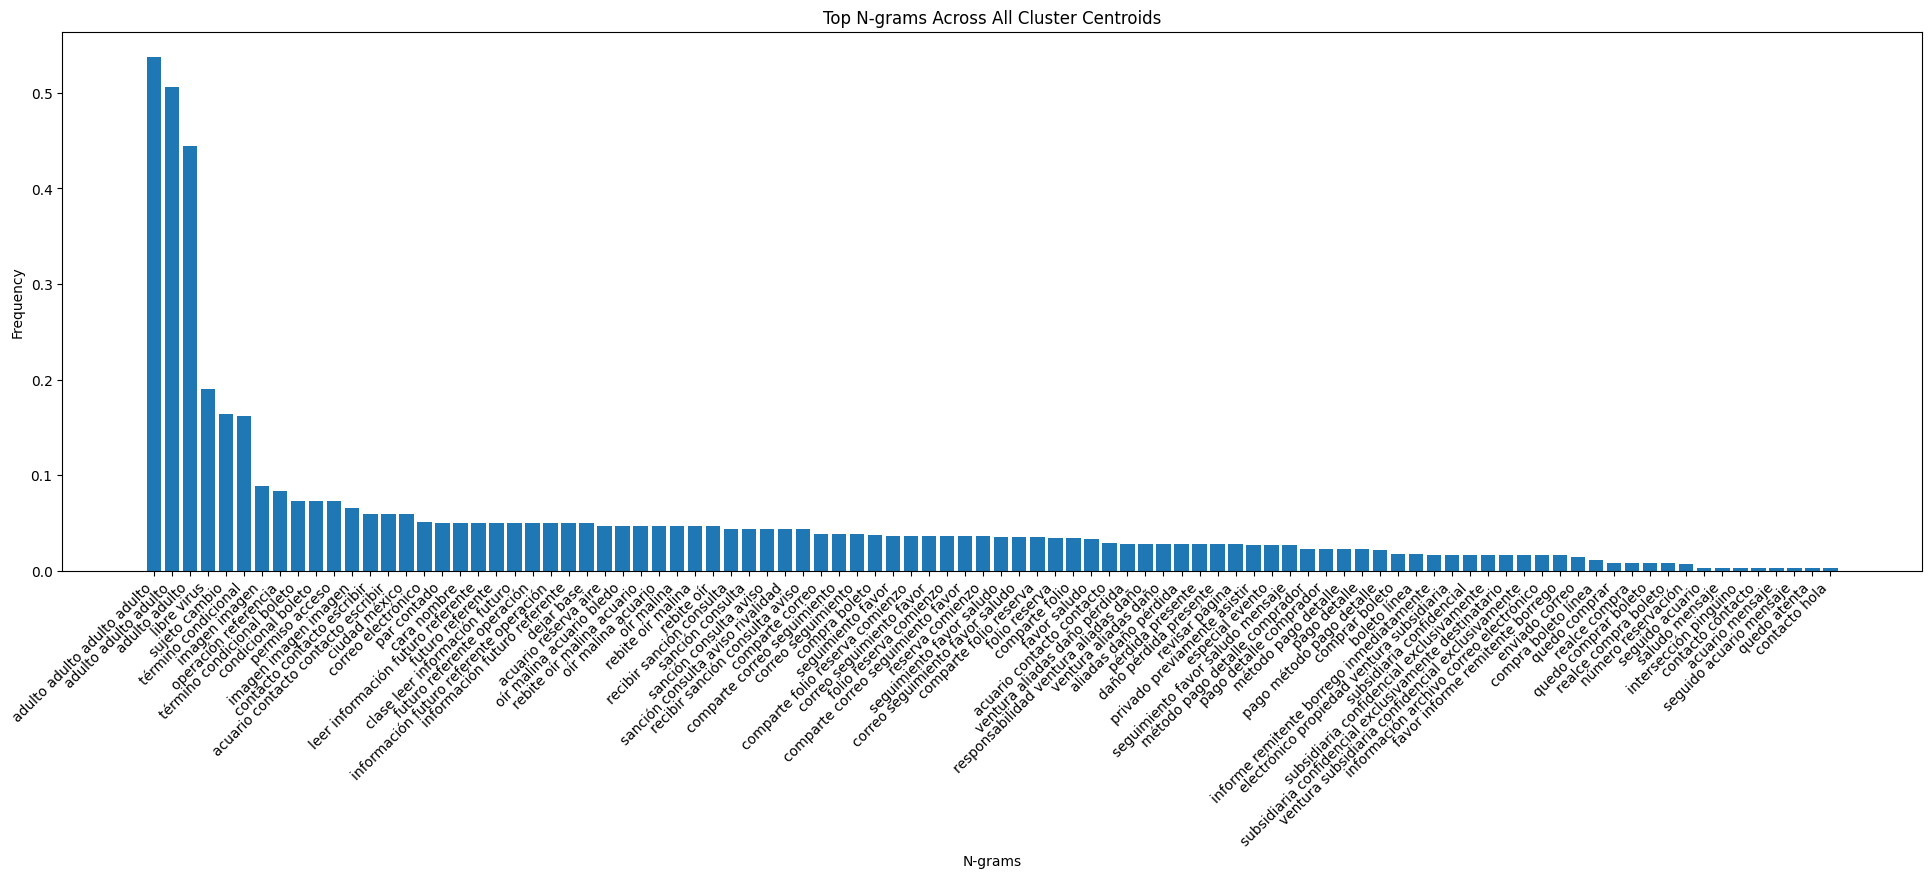

In [ ]:

# Sort n-grams by their frequency
sorted_ngrams = sorted(top_ngrams.items(), key=lambda item: item[1], reverse=True)

# Separate keys and values for plotting
ngrams, frequencies = zip(*sorted_ngrams)

# Create bar chart
plt.figure(figsize=(24, 7))
plt.bar(ngrams, frequencies)
plt.xlabel('N-grams')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.title('Top N-grams Across All Cluster Centroids')
plt.show()


# Conclusiones
### Ngrams con contenido relevante:

* Operación referencia, Folio reserva, Comparte Folio -> Referencia sobre la operación; reserva, compra<br><br>

* Permiso acceso -> Datos sobre acceso a las instalaciones<br><br>

* Acuario reserva -> Intención de reservación a acuario<br><br>

* Compra boleto, compra boleto Línea -> Intención de commpra de boleto, Intención compra de boleto en línea<br><br>

* Especial Evento -> Reservas para evento especial<br><br>

* Detalle pago, Método pago -> Pedir información sobre método de pago<br><br>

* Intersección pingüino -> Esto resulta ser un error en la corrección de errores ortográficos. Los clientes buscan detalles sobre la interacción con pingüinos.<br><br>

# Resolución de preguntas

#### ¿Hay valores faltantes en el conjunto de datos? ¿Se pueden identificar patrones de ausencia?

`El alcance definido inicialmente incluía únicamente una unidad de negocio de Ventura Entertainment. Debido a que la base de datos contiene muy poca información para extraer contenido relevante, se extendió el alcance a dos unidades de negocio más: Acuario Inbursa y Acuario Bajío. Esto facilitó la creación de clusters para agrupar los mensajes que los clientes envían a las cuentas de contacto de estos negocios. En concliusión, sí había una falta de información pero se ha mitigado al agregar dos fuentes de información con suficientes características similares`


#### ¿Cuáles son las estadísticas resumidas del conjunto de datos?

`Debido a la naturaleza no cuantitativa de nuestros datos, las estadísticas generales que podemos proveer son:`<br>
* `Cuenta de mensajes totales: 26008`<br>
* `Cuenta de direcciones únicas de correo electrónico de clientes: 3563`<br>
* `Cuenta de mensajes decodificados 8346`
* `Distribución de recepción de mensajes a través del tiempo:`

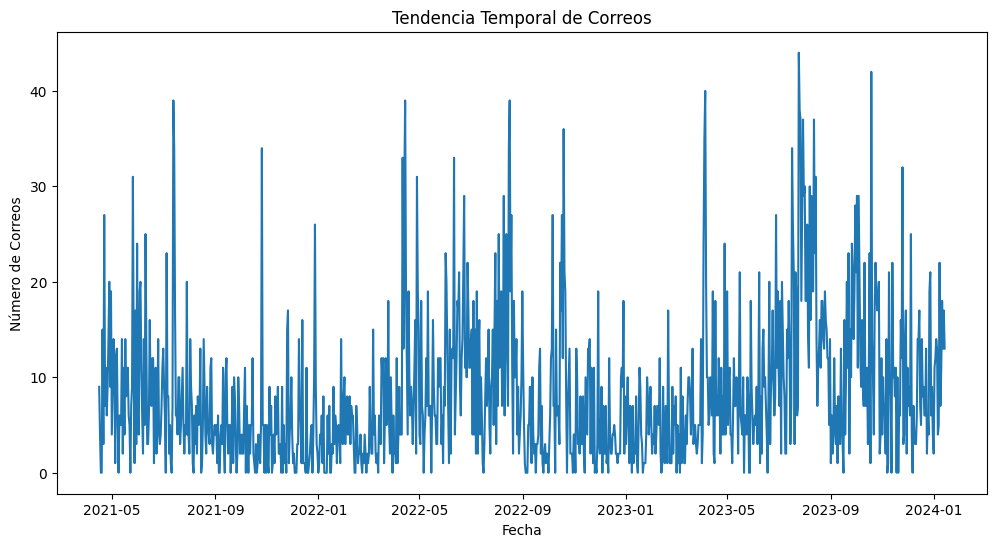

In [ ]:
# Identificar tendencias temporales y visualizar los datos a lo largo del tiempo
df_messages['date'] = pd.to_datetime(df_messages['date'], utc=True)

# Agrupar por fecha y contar el número de correos por día
daily_count = df_messages.resample('D', on='date').size()

# Visualizar la serie temporal
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_count)
plt.title('Tendencia Temporal de Correos')
plt.xlabel('Fecha')
plt.ylabel('Número de Correos')
plt.show()


### Como siguiente paso para hacer el anális más granular podríamos segmentar los correos en temporadas altas y bajas. Esto queda como una cualidad de mejora potencial en este estudio.

### ¿Hay valores atípicos en el conjunto de datos?

`Sí existen valores atítpicos en el estudio. Los ngrams muestran información repetitiva si los stopwords son eliminados, algunos ngrams extraños son "adulto adulto adulto" y "libre virus". Este último parece venir de firmas automáticas en mensajes recibidos pues se afirma la recepción de un mensaje libre de virus. El primero es contenido que lista el tipo de boleto "adulto" que se ha reservado/comprado. Estos valores atípicos tampoco agregan información relevante al análisis y es dificil filtraros pues en la comunicación se han mezclado las conversaciónes del personal de Ventura Entertainment con los clientes.`

### ¿Cuál es la cardinalidad de las variables categóricas?

`La cardinalidad de las variables es baja, pues los clusters con ngrams muestran estos últimos repetidos en varios de ellos. Esto signigfica que el contenido de cada cluster tiene superposición con los demás. `

### ¿Existen distribuciones sesgadas en el conjunto de datos? ¿Necesitamos aplicar alguna transformación no lineal?

`Debido a la naturaleza no cuantitativa de la información no se puede sugerir que las distribuciones estén sesgadas. Tampoco podríamos sugerir una normalización de la información.`

### ¿Se identifican tendencias temporales? (En caso de que el conjunto incluya una dimensión de tiempo).

`Si se han identificado tendencias temporales, Pues se nota claramente la alta afluencia de mensajes en temporadas altas. Se ha definido que como siguiente paso para este estudio podría llevarse a cabo una segmentación en temporadas altas y temporadas bajas.`

### ¿Hay correlación entre las variables dependientes e independientes?

`En este caso no podríamos definir directamente variables dependientes e independientes. De ser estricto en su definición, los clusters serían las variables dependientes y los vectores TF-IDF las variables independientes. La correlación entre ellos la hemos definido al establecer el método de clustering mas no podríamos definirla como se hace cuantitativamente con la varianza.`

### ¿Cómo se distribuyen los datos en función de diferentes categorías?

``Los datos se distribuyen en ngrams que se repiten en los clusters definidos y visualizados en el último pareto. También fueron interpretados en la sección de conclusiones. ``

### ¿Existen patrones o agrupaciones (clusters) en los datos con características similares?

``Sí, debido a la baja cardinalidad``

### ¿Se deberían normalizar las imágenes para visualizarlas mejor?

`No aplica`

### ¿Hay desequilibrio en las clases de la variable objetivo?

`Tampoco aplica pues estamos usando técnicas de prendizaje no supervisado; Kmeans.`